# Reviews Sentiment Prediction Experiment

# 0. Introduction

### For this experiment, we'll start out slowly by referring to the tutorial on kaggle: https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words. We will begin by familiarizing ourselves with its python tools and workflow, reproducing part of the steps in the blog, and then complete the 4 experiments to be described below.

### First, we'll import a couple of the libraries we need and check its version #'s. At the time of this writing, the version no.s are 0.18.1 for scikit-learn and 0.20.1 for pandas.

In [2]:
import pandas as pd
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('pandas version is {}.'.format(pd.__version__))

The scikit-learn version is 0.18.1.
pandas version is 0.20.1.


### We next read the training data file consisting of various reviews using pandas's built-in method, and verify the no. of rows and columns.

In [3]:
# Reading from the training data file.
# Here, "header=0" indicates that the first line of the file contains column names,
# "delimiter=\t" indicates that the fields are separated by tabs, and 
# quoting=3 tells Python to ignore doubled quotes, otherwise you may encounter errors trying to read the file.
train = pd.read_csv("labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [4]:
print(train.shape) #expected (rows, cols) value of (25000, 3)

(25000, 3)


### Let's check what the 3 columns consist of.

In [5]:
# the columnns are 'id', 'sentiment'(0 = negative, 1 = positive), and 'review' (the actual text of review)
train.columns.values

array(['id', 'sentiment', 'review'], dtype=object)

### Let's take a look at an example review in the very first row of the training data. The "id" column gives you the ID # of the review, the "review" column is the actual raw text of the review, and the "sentiment" column consists of either 0 (negative review) or 1 (positive review).

In [6]:
# Reading an example review, along with its id # and sentiment (0 = negative review, 1 = positive review)
print("ID: ", train["id"][0])
print("REVIEW TEXT: ", train["review"][0])
print("SENTIMENT: ", train["sentiment"][0])

ID:  "5814_8"
REVIEW TEXT:  "With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature 

### It will be useful to save just the "sentiment" column as a single vector to a variable Y (for training purposes later). Let's do this now.

In [7]:
# We will save the sentiment column as a Y value
Y = train["sentiment"].values # the .values attribute saves the column as a numpy array.
print (Y)
print (len(Y)) # Expected 25000
print(type(Y)) # numpy array type

[1 1 0 ..., 0 0 1]
25000
<class 'numpy.ndarray'>


### The raw review text contains html markings, punctuations, non-alphabetic characters and common "stop words" that generally do not aid us in ascertaining a review's sentiment. Thus, for purposes of training our predictor, we would prefer to have these removed from the raw text. We will proceed to do this now.

In [8]:
# We will use BeautifulSoup to parse the text
!pip install beautifulsoup4
from bs4 import BeautifulSoup

### We'll first test the html parser that removes html markings from the raw text.

In [10]:
example1 = BeautifulSoup(train["review"][0], "html.parser")
print (train["review"][0]  + "\n")  # the raw review text
print (example1.get_text()) # the review with html markings removed

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

### Next, let's use regular expressions to remove all non-alphabetic chars, and test it on a single review.

In [11]:
# We will further use regular expressions to parse the text further, by removing all non-alphabetic chars
import re
# Use regular expressions to do a find-and-replace
letters_only = re.sub("[^a-zA-Z]",           # The pattern to search for
                      " ",                   # The pattern to replace it with
                      example1.get_text() )  # The text to search
print (letters_only)

 With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring  Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him The actual feature film bit when it finally starts is only on for    mi

### For our purposes (sentiment analysis), there is no compelling reason to distinguish between capitalized and lowercase characters. So we'll turn all letters to lowercase. It's also a good idea to split the String to get a list, which is easier to work with.

In [12]:
lower_case = letters_only.lower()        # Convert to lower case
words = lower_case.split()               # Split into words to get a list
print(words)

['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'started', 'listening', 'to', 'his', 'music', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there', 'watched', 'the', 'wiz', 'and', 'watched', 'moonwalker', 'again', 'maybe', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'thought', 'was', 'really', 'cool', 'in', 'the', 'eighties', 'just', 'to', 'maybe', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilty', 'or', 'innocent', 'moonwalker', 'is', 'part', 'biography', 'part', 'feature', 'film', 'which', 'i', 'remember', 'going', 'to', 'see', 'at', 'the', 'cinema', 'when', 'it', 'was', 'originally', 'released', 'some', 'of', 'it', 'has', 'subtle', 'messages', 'about', 'mj', 's', 'feeling', 'towards', 'the', 'press', 'and', 'also', 'the', 'obvious', 'message', 'of', 'drugs', 'are', 'bad', 'm', 'kay', 'visually', 'impressive', 'but', 'of', 'course', 'this', 'is', 'all', 'about', 

### Now we'll use nltk to remove some common "stopwords" that don't contribute much to the meaning and thus aren't too helpful for training our sentiment classification predictor model. Again, we will test the stop words removal on a single review for now.

In [15]:
import nltk
# nltk.download()    # uncomment this if you haven't downloaded the stopwords corpora.
from nltk.corpus import stopwords
print("Stopwords:\n", stopwords.words("english")) # This is the list of stop words. These will be removed from the reviews

# Remove stop words from "words"
words_minus_stopwords = [w for w in words if not w in stopwords.words("english")]
print ("\nOrig. review with stop words removed::\n", words_minus_stopwords)

Stopwords:
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', '

### We will quickly verify how many stop words have been removed from the original review.

In [16]:
# Comparing the length of original list of words vs. list of words excluding stopwords
print (len(words))
print (len(words_minus_stopwords))

# Confirming that there are 437 - 219 = 218 stopwords that have been removed from the original list of words
diff = [a for a in words+words_minus_stopwords if (a not in words) or (a not in words_minus_stopwords)]
print(len(diff)) # this value should equal 437-219 = 218

437
219
218


### Remember, all of the above processing was one for just a single review. But we want to apply the processing to all the reviews in the training data. Thus we'll make a function to do this.

In [17]:
# Let's make a function to accomplish what we did above, since we'll be calling this function a lot of times
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed, "cleaned-up" movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "html.parser").get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than
    # searching a list, so we'll convert the stop words to a set
    stops = set(stopwords.words("english"))        #set of stopwords which we want to disregard
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops] 
#     print(len(meaningful_words))  # just testing
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result. We do this instead of returning the list because
    # returning this will make it easier to use with our Bag of Words model.
    return( " ".join( meaningful_words ))

### Now let's go through the entire training set of reviews and clean them all up at once, using the above function.

In [18]:
# Now let's go thru the entire training set of reviews and clean up all of them at once
# This might take a few minutes
# Get the number of reviews based on the dataframe column size
num_reviews = train["review"].size

# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
print ("Processing ", end="")
for i in range( 0, num_reviews ):
    # If the index is evenly divisible by 1000, print a message for user friendliness
    if( (i+1)%1000 == 0 ):
        print ("Review {} of {}...".format(i+1, num_reviews ), end="")
    # Call our function for each one, and add the result to the list of
    # clean reviews
    clean_train_reviews.append( review_to_words( train["review"][i] ) )
print("Done!")

Processing Review 1000 of 25000...Review 2000 of 25000...Review 3000 of 25000...Review 4000 of 25000...Review 5000 of 25000...Review 6000 of 25000...Review 7000 of 25000...Review 8000 of 25000...Review 9000 of 25000...Review 10000 of 25000...Review 11000 of 25000...Review 12000 of 25000...Review 13000 of 25000...Review 14000 of 25000...Review 15000 of 25000...Review 16000 of 25000...Review 17000 of 25000...Review 18000 of 25000...Review 19000 of 25000...Review 20000 of 25000...Review 21000 of 25000...Review 22000 of 25000...Review 23000 of 25000...Review 24000 of 25000...Review 25000 of 25000...Done!


### All the reviews in the training data set should now be parsed and processed. We will verify this by looking at one of the reviews.

In [19]:
print("Example of a processed review:\n", clean_train_reviews[0]) #Testing
print("\nTotal No. of reviews that have been processed: ", len(clean_train_reviews)) # Should be 25000 reviews

Example of a processed review:
 stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequenc

In [20]:
print(type(clean_train_reviews[0])) # should be str

<class 'str'>


# 1. Processing text to design matrices
### Now that we have a parsed, processed list of all 25,000 reviews, we will create 4 different design matrices with which to train our review sentiment predictor, as follows:

X_counts, X_binary, X_tfidf, and X_binary_imbalance will be created. The properties of each matrix are:

X_counts contains the raw word counts (the blog mentioned at the top of this experiment also does this, so in this case we aren't doing anything too different). 

X_binary modifies X_counts so that all elements are either 0 or 1. 

X_tfidf modifies X_counts by applying the sklearn tfidf vectorizer (http://scikit-learn.org/stable/modules/feature_extraction.html) with smooth_idf=false.

For X_binary_imbalance, we'll start with X_binary, set our rng seed to 0 and then delete 75% of the rows at random corresponding to sentiment=1, thus creating an imbalanced data set.

### First, we will create X_counts by using sklearn's CountVectorizer. As implemented below, X_counts can be understood as a 2-D numpy array with 25000 rows and 5000 columns, corresponding to 25000 reviews and 5000 "features" (a.k.a. 5000 words in our vocabulary). In other words, each of the 25000 rows contains 5000 elements, where each element is the count of a corresponding word in the 5000-word vocabulary.

### (Why is the vocabulary only 5000 words? This is a constraint that we decided to impose when initializing CountVectorizer (see code comments below) for efficiency reasons.)

In [21]:
# Now that we have a clean list of all 25,000 reviews, let's create a Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
# Note that CountVectorizer comes with its own options to automatically do 
# preprocessing, tokenization, and stop word removal -- for each of these, 
# instead of specifying "None", we could have used a built-in method 
# or specified our own function to use.  
# See the function documentation for more details 
# (http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
# However, we wanted to write our own function for data cleaning in this experiment 
# for academic purposes, so it's not necessary to use these parameters here.

# Also note that we capped max_features at 5000. This will limit the # of vocabulary to 
# 5000 max_features ordered by term frequency across the corpus.
# This is done mostly for efficiency reasons.
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
print (vectorizer)

print ("Creating the bag of words...", end = "")

# fit_transform() performs two roles: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
X_counts = vectorizer.fit_transform(clean_train_reviews)

print("Done.")
print ("The dimension of X_counts (expected 25000, 5000): ", X_counts.shape)
print("Type of X_counts (before conversion to nparray): ", type(X_counts))

X_counts = X_counts.toarray() # Convert to np array to make it easier to work with
print("Type of X_counts (after conversion): ", type(X_counts))
print("Printing first row of X_counts for testing...\n", [element for element in X_counts[0]]) # Printing first row for testing

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
Creating the bag of words...Done.
The dimension of X_counts (expected 25000, 5000):  (25000, 5000)
Type of X_counts (before conversion):  <class 'scipy.sparse.csr.csr_matrix'>
Type of X_counts (after conversion):  <class 'numpy.ndarray'>
Printing first row of X_counts for testing...
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Now we will create X_binary. As the name implies, this is the same matrix as X_count except that each element in X_binary is either 0 (if the corresponding element in X_count is 0) or 1 (if the corresponding element in X_count is greater than 0).

In [22]:
X_binary = X_counts.copy()    # X_binary will turn all nonzero elements in X_count into 1, and everything else to 0.
X_binary[X_binary > 0] = 1    # Using vectorization to do what I stated above
print ("Printing first row of X_binary for testing...\n", [element for element in X_binary[0]]) # Printing first row for testing

Printing first row of X_binary for testing...
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

### Next, we create X_tfidf, using sklearn's Tfidf Vectorizer.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer  
tfidf_vectorizer = TfidfVectorizer(analyzer = "word",
                                   tokenizer = None,
                                   preprocessor = None,
                                   stop_words = None,
                                   max_features = 5000,
                                   smooth_idf = False)

print(tfidf_vectorizer)
X_tfidf = tfidf_vectorizer.fit_transform(clean_train_reviews)
print ("The dimension of X_tfidf (expected 25000, 5000): ", X_tfidf.shape)
X_tfidf = X_tfidf.toarray()
print ("Printing first row of X_tfidf for testing...\n", [element for element in X_tfidf[0]]) # Testing

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=False,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)
The dimension of X_tfidf (expected 25000, 5000):  (25000, 5000)
Printing first row of X_tfidf for testing...
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.067925543347794506, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

### Finally, we create X_binary imbalance. We do this by taking the X_binary we created above and randomly removing 75% of the rows with sentiment values of 1 each.

In [27]:
# For the X_binary_imbalance, start with X_binary, set your rng seed to 0 (for consistency when testing)
# and then delete 75% of the rows corresponding to sentiment=1
import random
import numpy as np
random.seed(0)

# Begin by saving all the indices in X_binary with a sentiment of 1.
sentiment1_indices = [i for i in range(len(X_binary)) if train['sentiment'][i] == 1]
numElementsWSentiment1 = len(sentiment1_indices)
print ("No. of indices that have a sentiment of 1:", numElementsWSentiment1)               # expected 12500

# Double-checking. This should be equal to the number above (comment out once verified)
# numElementsWSentiment1 = len(train[train['sentiment'] == 1])  
# print (numElementsWSentiment1)               # expected 12500

# Triple-checking. sum should be equal to the number we got above. (comment out once verified)
# numElementsWSentiment1 = 0
# for sentiment in train['sentiment']:
#     if (sentiment == 1):
#        numElementsWSentiment1 += 1
# print (numElementsWSentiment1)

# Now randomly delete 75% of the indices with sentiment == 1. In other words retain only 25%.
print("We will randomly keep 25% of these indices. Trimming...")
numIndicesToKeep = int(numElementsWSentiment1 / 4)  # we will keep 25%
indices_to_keep = set(random.sample(sentiment1_indices, numIndicesToKeep)) # this will randomly pick the indices to keep.
print("No. of indices to keep:", len(indices_to_keep))
print("The actual indices we will keep:\n",indices_to_keep) #Testing

# Now create matrix that copies X_binary except it retains only the indices_to_keep, 
# as well as all other indices with sentiment == 0
X_binary_imbalance = np.array([X_binary[i] for i in range(len(X_binary)) if i in indices_to_keep or train['sentiment'][i] == 0])
print("The dimension of X_binary_imbalance (expected (15625, 5000)): ", X_binary_imbalance.shape) #Expected (15625, 5000)

No. of indices that have a sentiment of 1: 12500
We will randomly keep 25% of these indices. Trimming...
No. of indices to keep: 3125
The actual indices we will keep:
 {1, 8196, 5, 8198, 24584, 9, 12, 8205, 8208, 18, 24595, 16404, 19, 22, 24599, 8217, 24607, 36, 16421, 38, 16423, 40, 8234, 24620, 8239, 47, 16434, 51, 16437, 57, 16445, 8255, 66, 24643, 8267, 24653, 8270, 8272, 81, 8274, 8277, 86, 8279, 24665, 16477, 16478, 24674, 103, 8296, 8297, 16488, 8301, 24688, 112, 16497, 115, 8307, 16501, 24695, 16506, 123, 16508, 8318, 8320, 8323, 24708, 133, 24710, 134, 16515, 24713, 138, 16530, 24724, 8341, 150, 8342, 148, 8350, 8351, 16544, 160, 16542, 24741, 8360, 16555, 172, 8365, 24750, 24749, 24753, 8372, 8376, 185, 8378, 8379, 24763, 24761, 24767, 8387, 24773, 24775, 16584, 201, 24776, 16589, 207, 8400, 24786, 24787, 16596, 8405, 24790, 24791, 8402, 214, 16614, 24807, 232, 16615, 16618, 8428, 24813, 24815, 8431, 24821, 16631, 8441, 249, 253, 16638, 255, 8448, 257, 24835, 8452, 8455, 2484

The dimension of X_binary_imbalance (expected (15625, 5000)):  (15625, 5000)


### Note that, because we deleted 75% of the rows with sentiment of 1, X_binary_imbalance has only 15625 rows, whereas all the other design matrices each have 25000 rows. This means that the original training data (which also has 25000 rows) will be out of aligment with X_binary_imbalance -- that is, the indices of X_binary_imbalance will not correspond to the correct review in the original training data.

### To fix this, we will make a copy of the training data with the same indices taken out. We will also do the same to the sentiment vector, Y, which we created above as well.

In [28]:
# Save a separate array of the training data with the same indices taken out as in X_binary_imbalance
train_nparray = train.values
train_imbalance = np.array([train_nparray[i] for i in range(len(train_nparray)) if i in indices_to_keep or train['sentiment'][i] == 0])
print(train_imbalance.shape) #Expected (15625, 3)

# Save a separate array of just the sentiment data corresponding to X_binary_imbalance
Y_imbalance = np.array([Y[i] for i in range(len(Y)) if i in indices_to_keep or train['sentiment'][i] == 0])
print(Y_imbalance.shape)  #Expected (15625, )

(15625, 3)
(15625,)


# 2. Feature space similarity experiment
### We will take the four design matrices we created in the previous section (X_counts, X_binary, X_tfidf, X_binary_imbalance) and compute the Euclidean distance between every pair of the reviews. Since each design matrix has saved the reviews in vectorized form, with each review represented by the "bag of words" in the 5,000-word vocabulary, computing this distance should give us some (hopefully) useful information about what it means for two reviews to be very "alike" or "different". 

### Afterwards, we will look at the closest pair of reviews for each design matrix and compare them. Specifically, then, we will:

Write a function dist(X, i, j, distance_function='Euclidean') which returns the (Euclidean) distance between rows i and j of a design matrix. Also write a function topk(X, k) which returns ((i1,j1,d1),...(ik,jk,dk)) where (ix,jx) are the indices of the xth closest pair, and dx is the corresponding distance. We will break ties randomly. Then we'll use topk() to find the closest review pairs for each design matrix and print the following: the indices of the reviews, the distance, the first 20 characters of each review, the labels for each review. Then we'll observe whether the pairs are always the same or not for each design matrix.

### We will begin by creating the dist(X, i, j, distance_function = 'Euclidean') method, and testing it with a small example.

In [29]:
from scipy.spatial import distance
# import math

# Write a function dist(X, i, j, distance_function=’Euclidean’) which returns the
# (Euclidean) distance between rows i and j of a design matrix

def dist(X, i, j, distance_function = 'Euclidean'):
    row_i = X[i]
    row_j = X[j]
    # Using pdist function from scipy to get the distances between all rows
    distance_function = distance_function.lower() # Convert the distance_function parameter to lowercase
    d = distance.pdist(X, distance_function)  # Invoke built-in function with the parameter.
#     print (d)
    d = distance.squareform(d)  # This turns the result into a 2D array.
    print("Resulting 2D array of distances:\n", d)                    # Printing out the result for testing
    return d[i][j]              # Returning the distance between row i and j
    
    # Alternate way to manually compute the distance between row i and j (commented out)
#     sum = 0
#     for k in range(len(row_i)):
#         sum += (row_i[k] - row_j[k])**2
#     return math.sqrt(sum)


# Testing
X = [[1,3,4],[2,1,0],[3,3,3]]
print("Creating a small design matrix, X, for purposes of testing the dist() method:")
print("X = ", X)
print("\nCalling dist(X, 0, 1)...")
euc_dist = dist(X, 0, 1)

#Expected sqrt((1-2)^2 + (3-1)^2 + (4-0)^2) = 4.58257569496
print ("\nEuclidean distance between row 0 and 1 of design matrix X:\n\
(Expected answer: sqrt((1-2)^2 + (3-1)^2 + (4-0)^2) = 4.58257569496)\n",\
euc_dist)

Creating a small design matrix, X, for purposes of testing the dist() method:
X =  [[1, 3, 4], [2, 1, 0], [3, 3, 3]]

Calling dist(X, 0, 1)...
Resulting 2D array of distances:
 [[ 0.          4.58257569  2.23606798]
 [ 4.58257569  0.          3.74165739]
 [ 2.23606798  3.74165739  0.        ]]

Euclidean distance between row 0 and 1 of design matrix X:
(Expected answer: sqrt((1-2)^2 + (3-1)^2 + (4-0)^2) = 4.58257569496)
 4.58257569496


### Next, we'll write the topk(X, k) method. This method could invoke the dist() method we wrote above, but instead we will use sklearn's built-in euclidean_distances method for even greater efficiency. We will then test the method with a small example.

In [30]:
from sklearn.metrics.pairwise import euclidean_distances
import heapq
import math

# returns ((i1,j1,d1),...(ik,jk,dk)) where (ix,jx) are the indices of the xth
# closest pair, and dx is the corresponding distance. You can break ties randomly.
def topk(X, k):
    
    # Get distance between every pair of rows of X
    d = euclidean_distances(X,X)
#     print(d)
    
    # We will use a heap to "sort" the distances, only keeping the top k results at all times to save space.
    h = []
    
    # Go thru each pair. We make sure that pairs will not repeat by having j range from i+1 to len(d[i]).
    # For example, (1,0) will not show up since it is a repeat of the pair (0,1).
    for i in range(len(d)):
        for j in range(i+1, len(d[i])):
            # We multiply the distance by -1 here, because we want to "pop" the largest elements out as we
            # add more elements to the heap. But by default, the heap pops out the smallest elements instead,
            # thus we multiply by -1 here.
            heapq.heappush(h, (-1 * d[i][j], i, j)) 
            if (len(h) > k):  # Only keep k elements at most in the heap
                heapq.heappop(h)
    
    # Now we initialize the list that will be returned. This list will consist of k elements or,
    # if k > the total no. of rows in X, then the list will consist of len(X) elements instead.
    # (After all, we can't return a list containing more elements than the design matrix X does!)
    k = min(k, len(h))
    ret = [0 for x in range(k)]  # initialize an array with all zeroes

    # We will iterate backwards from k-1 down to 0, filling up the largest distance in the heap down to the smallest distance.
    # The result is that smallest distance will end up in the 0th index position
    for i in range(k-1, -1, -1):
        # Although heappop removes smallest element by default, we multiplied each element by -1 
        # in the for loop above, so we're really removing the largest element in the heap)
        tup = heapq.heappop(h)
        # We again multiply by -1 here to "undo" the multiplcation by -1 that we did in the loop above.
        ret[i] = (tup[1], tup[2], -1 * tup[0]) # tup[1] and tup[2] indicate the pair of rows, and -1*tup[0] indicates the distance
    return ret

print("Preparing to test the topk() method with the following design matrix:")
print("X = ", X)

print ("topk(X, 0) = ", topk(X, 0)) # should be empty
print ("topk(X, 1) = ", topk(X, 1)) # expected [(0, 2, 2.2360679774997898)]
print ("topk(X, 2) = ", topk(X, 2)) # expected [(0, 2, 2.2360679774997898), (1, 2, 3.7416573867739413)]
print ("topk(X, 3) = ", topk(X, 3)) # expected [(0, 2, 2.2360679774997898), (1, 2, 3.7416573867739413), (0, 1, 4.5825756949558398)]
print ("topk(X, 4) = ", topk(X, 4)) # expected same output as topk(X, 3) since X only contains 3 rows.

Preparing to test the topk() method with the following design matrix:
X =  [[1, 3, 4], [2, 1, 0], [3, 3, 3]]
topk(X, 0) =  []
topk(X, 1) =  [(0, 2, 2.2360679774997898)]
topk(X, 2) =  [(0, 2, 2.2360679774997898), (1, 2, 3.7416573867739413)]
topk(X, 3) =  [(0, 2, 2.2360679774997898), (1, 2, 3.7416573867739413), (0, 1, 4.5825756949558398)]
topk(X, 4) =  [(0, 2, 2.2360679774997898), (1, 2, 3.7416573867739413), (0, 1, 4.5825756949558398)]


### We are now ready to invoke the topk() method above for each of the 4 design matricees. We will let k = 50, meaning the method will return the 50 shortest distances (along with the corresponding pair of rows).

In [31]:
distances_xcounts = topk(X_counts, 50) # each of these may take a few minutes depending on your system

In [32]:
distances_xbinary = topk(X_binary, 50)

In [33]:
distances_xtfidf = topk(X_tfidf, 50)

In [34]:
distances_xbinary_imbalance = topk(X_binary_imbalance, 50)

In [35]:
print(distances_xcounts)
print(distances_xbinary)
print(distances_xtfidf)
print(distances_xbinary_imbalance)

[(22599, 23581, 0.0), (21186, 21877, 0.0), (19463, 21339, 0.0), (19177, 21292, 0.0), (17910, 24442, 0.0), (17736, 18042, 0.0), (17342, 21172, 0.0), (17050, 19737, 0.0), (17045, 23321, 0.0), (16969, 22922, 0.0), (16502, 19613, 0.0), (15426, 21441, 0.0), (15381, 23160, 0.0), (15290, 18042, 0.0), (15290, 17736, 0.0), (14935, 24983, 0.0), (14783, 22344, 0.0), (14767, 22244, 0.0), (14104, 22961, 0.0), (14037, 24500, 0.0), (13371, 17878, 0.0), (13159, 16990, 0.0), (12399, 17018, 0.0), (12394, 24781, 0.0), (11769, 22499, 0.0), (11550, 24848, 0.0), (11377, 24576, 0.0), (11005, 20550, 0.0), (10893, 12699, 0.0), (10709, 14504, 0.0), (10506, 14949, 0.0), (10374, 10941, 0.0), (9838, 22087, 0.0), (9776, 22278, 0.0), (9316, 19818, 0.0), (8748, 23538, 0.0), (8741, 22449, 0.0), (8434, 12462, 0.0), (8418, 17935, 0.0), (8411, 12541, 0.0), (8358, 22911, 0.0), (8255, 19847, 0.0), (8117, 8136, 0.0), (8087, 10416, 0.0), (7765, 22278, 0.0), (7765, 9776, 0.0), (7667, 12234, 0.0), (7398, 14974, 0.0), (7310, 17

### For each design matrix, we will print the indices of the closest pair of reviews, the distance, the first 20 characters of the review, and the sentiment labels for each review.

In [37]:
distances_list = [(distances_xcounts, "X_counts"), 
                  (distances_xbinary, "X_binary"),
                  (distances_xtfidf, "X_tfidf"),
                  (distances_xbinary_imbalance, "X_binary_imbalance")]

for tupl in distances_list:    
    print ("Closest review pair for {}:".format(tupl[1]))
    dist = tupl[0]
    print (dist[0])
    # X_binary_imbalance is a special case, corresponding training data is train_imbalance, not train
    if (tupl[1] == "X_binary_imbalance"):
        print ("First 20 characters of review index {}: {}".format(dist[0][0], train_imbalance[dist[0][0]][2][:20]))
        print ("First 20 characters of review index {}: {}".format(dist[0][1], train_imbalance[dist[0][1]][2][:20]))
        print ("Sentiment of review index {}: {}".format(dist[0][0], train_imbalance[dist[0][0]][1]))
        print ("Sentiment of review index {}: {}".format(dist[0][1], train_imbalance[dist[0][1]][1]))
        print ("Distance: {}\n".format(dist[0][2]))
    else:
        print ("First 20 characters of review index {}: {}".format(dist[0][0], train["review"][dist[0][0]][:20]))
        print ("First 20 characters of review index {}: {}".format(dist[0][1], train["review"][dist[0][1]][:20]))
        print ("Sentiment of review index {}: {}".format(dist[0][0], train["sentiment"][dist[0][0]]))
        print ("Sentiment of review index {}: {}".format(dist[0][1], train["sentiment"][dist[0][1]]))
        print ("Distance: {}\n".format(dist[0][2]))

Closest review pair for X_counts:
(22599, 23581, 0.0)
First 20 characters of review index 22599: "I loved this movie.
First 20 characters of review index 23581: "I loved this movie.
Sentiment of review index 22599: 1
Sentiment of review index 23581: 1
Distance: 0.0

Closest review pair for X_binary:
(22599, 23581, 0.0)
First 20 characters of review index 22599: "I loved this movie.
First 20 characters of review index 23581: "I loved this movie.
Sentiment of review index 22599: 1
Sentiment of review index 23581: 1
Distance: 0.0

Closest review pair for X_tfidf:
(19463, 21339, 0.0)
First 20 characters of review index 19463: "Bette Midler showca
First 20 characters of review index 21339: "Bette Midler showca
Sentiment of review index 19463: 1
Sentiment of review index 21339: 1
Distance: 0.0

Closest review pair for X_binary_imbalance:
(13274, 13676, 0.0)
First 20 characters of review index 13274: "<br /><br />Back in
First 20 characters of review index 13676: "<br /><br />Back in
Sentimen

### Unsurprisingly, the closest pairs are not always the same for each of the four design matrices. In the next section, we will train an SVM classifier using these matrices and observe the performance of each.

# 3. Classification experiment

Now you’re going to tune an SVM classifier using each design matrix, and measure the resultant performance. Read the sklearn docs ( http://scikit-learn.org/stable/modules/cross_validation.html ) on cross-validation for information on the methods we use. We will adhere to the following scheme:

● Set rng seed to 0 and create an initial learning_set / test_set split of 80-20.

● Use a linear SVM ( svm.SVC with kernel=linear ) and pick the best C value for our classifier.

----○ Repeat for each of the four design matrices:

--------■ Repeat 30 times:

------------● Pick a random value of C uniformly in the logarithmic interval (1e-4, 1e4)

------------● Use 5-fold cross-validation to train the SVM

------------● Estimate and record the ROC-AUC

--------■ Select the value of C which produced the best ROC-AUC measurement

--------■ Retrain the classifier using the entire learning set with this C value

--------■ Generate an ROC curve and annotate with the ROC-AUC

--------■ Submit test set predictions to Kaggle (making sure we use Kaggle's test data -- we may need to retrain one more time using all "training data"). Document the resulting Kaggle score.

Afterwards, we will discuss which design matrix performed best (e.g., which encoding method worked best), and the
lift (improvement in AUC-ROC) between the worst and best cases for each experiment.

### We will begin by importing some of the libraries we will use in this section.

In [38]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt

### Let's create a method that performs classification using LinearSVC. The default parameters include 5-fold cross validation along with 30 loops. Parameters are as follows:

X_train is the training data containing one of the design matrices

Y_train is the corresponding training data containing sentiment labels

X_str is a String just to identify which design matrix we're working with (for user-friendliness)

folds is the no. of folds to be used for the K-Fold cross validation

loops is the no. of times we repeat the training

The below function returns a tuple (auc, fpr, tpr, c) containing the highest value of AUC found, along with corresponding false positive / true positive rates and the value of C that was used to initialize LinearSVC.

In [39]:
def k_fold_linearsvc_classification(X_train, Y_train, X_str, folds=5, loops=30):
    
    # Initialize list of tuples, where each tuple will be in the form (mean_auc, mean_fpr, mean_tpr, C),
    # where mean_auc is the mean area under the curve measurement that we will conduct below,
    # mean_fpr and mean_tpr are the mean false positive rate and mean true positive rate which we need for graphing,
    # and C = the C parameter used when initializing the LinearSVC classifier.
    roc_auc_list = []
    
    print("Starting {}-fold cross-validation on the training set for {} (repeating {} times)...".format(
                                                                                        folds, X_str, loops))
    
    # Repeat the following a total of L times, where L = the loops parameter above
    for i in range(loops):
        print ("Loop {}...".format(i), end="")
        # Run classifier with cross-validation and plot ROC curves
        cv = KFold(n_splits=folds)
        c = np.random.uniform(np.log(1e-4), np.log(1e4)) # random. uniformly distributed over log (1e-4) to log (1e4)
        c = np.exp(c)                                    # Convert to actual value between 1e-4 and 1e4
#         print("C = {}".format(c))
        classifier = LinearSVC(C = c)

        mean_tpr = 0.0                     # Mean true positive rate
        mean_fpr = np.linspace(0, 1, 100)  # Mean false positive rate

        # We will use a cycle list to cyclically loop thru each color (for variety and visibility in the resulting ROC graph)
        # UPDATE: not needed.
#         colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
#         lw = 2  # this is the line width that we will use for plotting

        # Perform 5-fold cross validation, and estimate / record the roc-auc along with the C value used.
        for (train, test) in cv.split(X_train, Y_train):
            # LinearSVC is faster than SVC, but does not come with the predict_proba() function like SVC does.
            # So we will instead use the decision_function() method.
        #     probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
            decision_func = classifier.fit(X_train[train], Y_train[train]).decision_function(X_train[test])

            # If we had used predict_proba() method above, then we'd be computing the false positive rate,
            # true positive rate and thresholds as below. But since we used decision_function() instead,
            # we must be careful that in this case decision_function() returns a 1D array,
            # whereas predict_proba() would've returned a 2D array.
            # Thus, instead of using the parameter probas_[:, 1],
            # we instead use decision_func[:]
        #     fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
            fpr, tpr, thresholds = roc_curve(Y_train[test], decision_func[:])
#             print("fpr, tpr = {}, {}".format(fpr, tpr))

            mean_tpr += interp(mean_fpr, fpr, tpr)  # Add up the mean true positive rate (to be divided later)
            mean_tpr[0] = 0.0
            # Use auc() method to compute Area Under Curve, where fpr = false positive rate (horizontal axis) 
            # and tpr = true positive rate (vertical axis)
            roc_auc = auc(fpr, tpr) 
#             print ("roc_auc: {}".format(roc_auc))
        #     plt.plot(fpr, tpr, lw=lw, color=color,
        #              label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        # End for (train, test), color in zip(...)
        
        # Now that we're done with the K-fold cross-validation, compute the mean
        mean_tpr /= cv.get_n_splits(X_train, Y_train)  # Compute mean positive rate
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)             # Compute mean area under the curve
        print("C, AUC: {}, {}".format(c, mean_auc))

        # Append the mean area under curve along with the c value we used in initializing LinearSVC.
        # We will later look thru the list to find the C-value that resulted in best auc.
        roc_auc_list.append((mean_auc, mean_fpr, mean_tpr, c))
    # End for i in range(loops)
    
    # Now that we're done with all the loops,
    # see which value of C performed the best, by sorting roc_auc_list and looking at the best (largest) mean_auc score
#     print("roc_auc_list before sort: {}".format(roc_auc_list))
    roc_auc_list.sort(key=lambda tup: tup[0], reverse = True)
#     print("roc_auc_list after sort: {}".format(roc_auc_list))
#     print("length of roc_auc_list: {}".format(len(roc_auc_list)))
    best_performer = roc_auc_list[0]
#     print("best performer: {}".format(best_performer))
    best_mean_auc = best_performer[0]
    best_mean_fpr = best_performer[1]
    best_mean_tpr = best_performer[2]
    best_C = best_performer[-1]
    
    worst_performer = roc_auc_list[-1]
    worst_mean_auc = worst_performer[0]
    worst_C = worst_performer[-1]
    
    print("Value of C that produced the best ROC-AUC measurement: {}\nCorresponding AUC value: {}".format(best_C, best_mean_auc))
    print("The lift (improvement in AUC) between the worst and best case for the design matrix {}: {}".format(
        X_str, best_mean_auc - worst_mean_auc))
    return best_performer

### Let us also create a method that will be used to grab the test data features (processed and transformed via CountVectorizer) from the Kaggle website, for purposes of testing the predictive performance of each of our four design matrices.
### Note that this method will only grab the data from the .tsv file if the given parameter equals None. Otherwise, it will simply return the parameter itself. (This is to save time in the event that we have previously grabbed the test data features and do not want to repeat the process)

In [40]:
def get_test_data_features(test = None, test_data_features = None):
    
    # If the parameter is None, then create it by reading from the data file.
    if test_data_features is None:
        # Read the test data
        print ("The test data file does not exist yet and must be created. Reading from the test data file...")
        test = pd.read_csv("testData.tsv", header=0, delimiter="\t", \
                           quoting=3 )

        # Verify that there are 25,000 rows and 2 columns
        print ("Verifying that our test data has 25000 rows and 2 columns: {}".format(test.shape))

        # Create an empty list and append the clean reviews one by one
        num_reviews = len(test["review"])
        clean_test_reviews = [] 

        print ("Cleaning and parsing the test set movie reviews...")
        for i in range(0,num_reviews):
            if( (i+1) % 1000 == 0 ):
                print ("Review {} of {}...".format(i+1, num_reviews), end="")
            clean_review = review_to_words( test["review"][i] )  # Call our custom function
            clean_test_reviews.append( clean_review )
        print("done.")

        print("Using CountVectorizer to transform the reviews and convert to numpy array...", end="")
        # Get a bag of words for the test set, and convert to a numpy array
        # Here, vectorizer is a CountVectorizer instance that we initialized previously
        test_data_features = vectorizer.transform(clean_test_reviews)
        test_data_features = test_data_features.toarray()
        print("done.\n")
    # end if
    
    return test, test_data_features

### We will now use the two functions that we wrote above to train and test the performance of each of our four design matrices. 
### We will initially split each matrix into 80 / 20 train/test sets before invoking the k_fold_linearsvc_classification() function.
### Afterwards, we will take the best-performing C-value, and re-train the 80% learning set of each design matrix, after which we will compute and graph the ROC_AUC curve.
### Finally, we will re-train 100% of the learning set and make predictions on the Kaggle test set, then print our predictions to a file to be submitted to Kaggle, after which we will report the Kaggle score for each design matrix.

    Training with X_counts...

Starting 5-fold cross-validation on the training set for X_counts (repeating 30 times)...
Loop 0...C, AUC: 2.457582078921003, 0.8985338087185609
Loop 1...C, AUC: 599.8102876237876, 0.8955488430019942
Loop 2...C, AUC: 1362.021635265945, 0.8953347393625519
Loop 3...C, AUC: 314.303943614508, 0.8953373350445654
Loop 4...C, AUC: 0.00037007390737761397, 0.9317234478761454
Loop 5...C, AUC: 4541.938732736456, 0.8954616536277066
Loop 6...C, AUC: 247.3252824567263, 0.8954044503849661
Loop 7...C, AUC: 58.21853031748783, 0.8955408528439134
Loop 8...C, AUC: 1.4955005393691556, 0.9004159561376356
Loop 9...C, AUC: 78.5860421857311, 0.8955844634389644
Loop 10...C, AUC: 8.731401853192574, 0.8963220986349286
Loop 11...C, AUC: 1662.6001074573285, 0.8954369661556566
Loop 12...C, AUC: 38.110931813691835, 0.8956146308734256
Loop 13...C, AUC: 0.0023295749146718314, 0.9421060098984956
Loop 14...C, AUC: 0.08122433559209678, 0.9240291547397699
Loop 15...C, AUC: 4694.551946357611, 

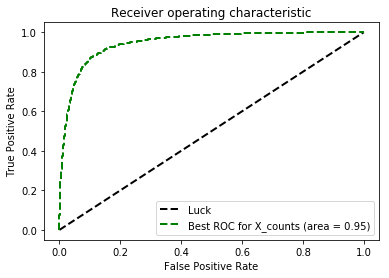

Now preparing to submit test set predictions to Kaggle.
We will retrain one last time using the best C value we found above, and
using ALL training data (100%) of the design matrix X_counts...

Now using our classifier to predict the sentiment label for each review in the test data...
The test data file does not exist yet and must be created. Reading from the test data file...
Verifying that our test data has 25000 rows and 2 columns: (25000, 2)
Cleaning and parsing the test set movie reviews...
Review 1000 of 25000...Review 2000 of 25000...Review 3000 of 25000...Review 4000 of 25000...Review 5000 of 25000...Review 6000 of 25000...Review 7000 of 25000...Review 8000 of 25000...Review 9000 of 25000...Review 10000 of 25000...Review 11000 of 25000...Review 12000 of 25000...Review 13000 of 25000...Review 14000 of 25000...Review 15000 of 25000...Review 16000 of 25000...Review 17000 of 25000...Review 18000 of 25000...Review 19000 of 25000...Review 20000 of 25000...Review 21000 of 25000...Revi

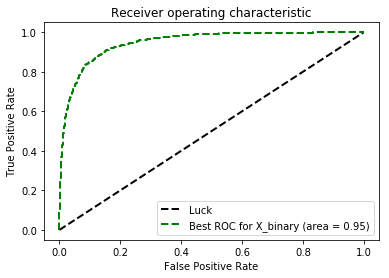

Now preparing to submit test set predictions to Kaggle.
We will retrain one last time using the best C value we found above, and
using ALL training data (100%) of the design matrix X_binary...

Now using our classifier to predict the sentiment label for each review in the test data...
Done predicting all sentiment labels. Outputting the predictions to X_binary_model.csv...
Finished!

    Training with X_tfidf...

Starting 5-fold cross-validation on the training set for X_tfidf (repeating 30 times)...
Loop 0...C, AUC: 20.166272195111308, 0.91429839996756
Loop 1...C, AUC: 1128.972059020623, 0.9039880075854962
Loop 2...C, AUC: 445.02831292127354, 0.9043253961467708
Loop 3...C, AUC: 0.25328665211013385, 0.9504099002517077
Loop 4...C, AUC: 31.615948181683816, 0.9112794440598306
Loop 5...C, AUC: 1102.5056529187552, 0.9040565947467649
Loop 6...C, AUC: 0.00016043597002095847, 0.9001913439660042
Loop 7...C, AUC: 14.795018022029385, 0.9168813259220592
Loop 8...C, AUC: 814.4132811911466, 0.903918

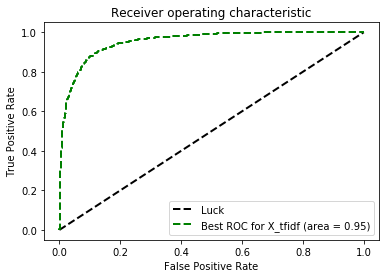

Now preparing to submit test set predictions to Kaggle.
We will retrain one last time using the best C value we found above, and
using ALL training data (100%) of the design matrix X_tfidf...

Now using our classifier to predict the sentiment label for each review in the test data...
Done predicting all sentiment labels. Outputting the predictions to X_tfidf_model.csv...
Finished!

    Training with X_binary_imbalance...

Starting 5-fold cross-validation on the training set for X_binary_imbalance (repeating 30 times)...
Loop 0...C, AUC: 766.3186419923878, 0.8878564426149506
Loop 1...C, AUC: 5.438526706268081, 0.8888849302074321
Loop 2...C, AUC: 0.44578405912400276, 0.8961337937845731
Loop 3...C, AUC: 0.2934349201937901, 0.8989664630020702
Loop 4...C, AUC: 0.0002849604654344569, 0.9068691206234392
Loop 5...C, AUC: 28.24054233936058, 0.8880090218131492
Loop 6...C, AUC: 0.015225628164924683, 0.9266970102272425
Loop 7...C, AUC: 2519.459646091068, 0.8878567978930565
Loop 8...C, AUC: 1.41475

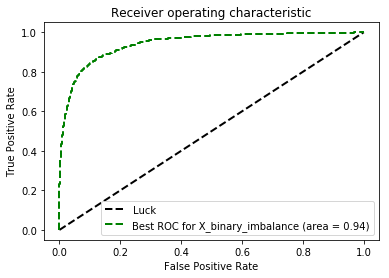

Now preparing to submit test set predictions to Kaggle.
We will retrain one last time using the best C value we found above, and
using ALL training data (100%) of the design matrix X_binary_imbalance...

Now using our classifier to predict the sentiment label for each review in the test data...
Done predicting all sentiment labels. Outputting the predictions to X_binary_imbalance_model.csv...
Finished!



In [41]:
np.random.seed(0)
lw = 2  # this is the line width that we will use for plotting

# Place into lists the 4 design matrices and corresponding Y (sentiment) vectors which we created in Section 2.
# We will iterate through these and train our model for each design matrix and gauge their performance
X_List = [X_counts, X_binary, X_tfidf, X_binary_imbalance]
X_Str_List = ["X_counts", "X_binary", "X_tfidf", "X_binary_imbalance"]
Y_List = [Y, Y, Y, Y_imbalance]

# The below 2 variables are parameters that will be fed into the invocation of get_test_data_features() method.
test = None
test_data_features = None

# Go thru each element in X_List and corresponding element in Y_List
for xi, yi in zip(range(len(X_List)), range(len(Y_List))):
    print("====================================================\n\
    Training with {}...\n====================================================\n".format(X_Str_List[xi])) # testing
    # Doing 80/20 split into training / test data
    X_train, X_test, Y_train, Y_test = train_test_split(X_List[xi], Y_List[yi], test_size=0.20, random_state = 0)
    best_performer = k_fold_linearsvc_classification(X_train, Y_train, X_Str_List[xi])  # Call custom function
    best_mean_auc = best_performer[0]
    best_mean_fpr = best_performer[1]
    best_mean_tpr = best_performer[2]
    best_C = best_performer[-1]
    
    print ("\nRetraining the classifier using the entire learning set of {} with the best C value of {}...".format(
        X_Str_List[xi], best_C))
    classifier = LinearSVC(C = best_C)
    decision_func = classifier.fit(X_train, Y_train).decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(Y_test, decision_func[:])
    roc_auc = auc(fpr, tpr)
    print("Done retraining. C, AUC = {}, {}".format(best_C, roc_auc))
    print("\nPlotting the ROC-AUC curve...")
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
                 label='Luck')
    plt.plot(fpr, tpr, color='g', linestyle='--',
         label='Best ROC for {:} (area = {:.2f})'.format(X_Str_List[xi], roc_auc), lw=lw)

    # Set the range of x-axis and y-axis for graphing purposes.
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", fontsize=10)
    plt.show()
    
    print("Now preparing to submit test set predictions to Kaggle.")
    print("We will retrain one last time using the best C value we found above, and\n\
using ALL training data (100%) of the design matrix {}...".format(X_Str_List[xi]), end="")
    classifier = LinearSVC(C = best_C)
    classifier = classifier.fit(X_train, Y_train)
    print("\n\nNow using our classifier to predict the sentiment label for each review in the test data...")
    test, test_data_features = get_test_data_features(test, test_data_features)  # Call custom method to get the bag of words representation of test data
    result = classifier.predict(test_data_features)
#     print(result)
    print("Done predicting all sentiment labels. Outputting the predictions to {}_model.csv...".format(X_Str_List[xi]))
    
    # Copy the results to a pandas dataframe with an "id" column and
    # a "sentiment" column
    output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

    # Use pandas to write the comma-separated output file
    output.to_csv( "{}_model.csv".format(X_Str_List[xi]), index=False, quoting=3 )
    print("Finished!\n")

### Now that we have made predictions using each of our four design matrices on the Kaggle test set, here are the resulting scores:
### Score for X_counts_model.csv: 0.87596
### Score for X_binary_model.csv: 0.87448
### Score for X_tfidf_model.csv: 0.87100
### Score for X_binary_imbalance_model.csv: 0.78824
### Best-performing model on the Kaggle test data: X_counts_model.csv

# 4. Learning curve experiment
### In this section, we will use a logistic regression classifier to generate a learning curve:
Using a logistic regression classifier and the design matrix X_counts, generate a learning curve:

● Set your rng seed to 0
● Generate a learning curve (xval vs training error) for n=(100, 500, 1000, 2000, 3000, 4000, 5000, 7500, 10000, 15000, 20000) training instances
● Interpret the learning curve

### We start by creating a function for plotting the learning curve, with the following parameters:

estimator is the type of model we use for prediction. In our case, we will use LogisticRegression.

title is a String, indicating the title of our learning curve.

X, y are the learning data and the correct labels.

ylim indicates the range of the y-axis in the graph.

cv indicates the number of folds in conjunction with our cross-validation strategy.

n_jobs is a parameter that will be fed into the learning_curve() method, indicating the number of jobs to run via parallel processing.

train_sizes is a parameter that will be fed into the learning_curve() method, indicating the numbers of training instances that will be used to generate the learning curve.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# See http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training instances")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### We will now apply a Logistic Regression classifier and use it along with the design matrix X_counts to generate a learning curve.

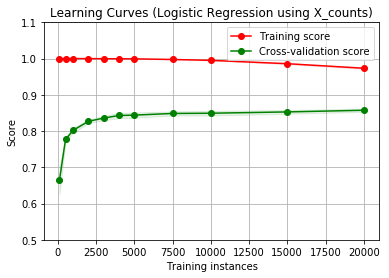

In [45]:
np.random.seed(0)
from sklearn.linear_model import LogisticRegression
title = "Learning Curves (Logistic Regression using X_counts)"
estimator = LogisticRegression()
plot_learning_curve(estimator, title, X_counts, Y, ylim=(0.5, 1.10), cv=5, \
                    train_sizes = np.array([100, 500, 1000, 2000, 3000, 4000, 5000, 7500, 10000, 15000, 20000]), n_jobs=4)
plt.show()

### The learning curve above shows among others that, when the training sample size is relatively small (100 ~ 2000), there is a large gap between the training score and cross-validation score. This is to be expected, since a reasonable learning model won't have much trouble fitting a small set of training data very well, but will likely not generalize well to the testing data due to the small sample size. Conversely, when the training sample size gets larger, the model is more likely to learn the vicissitudes (e.g. noise, etc.) of the training data and generalize better. Sure enough, as the training instances get larger, the gap between the two scores decreases.

### Overall, however, this learning curve may have a slight over-fitting (high variance) problem; even as the gap decreases towards the right side of the curve, the scores remain fairly far apart at the end (~0.97 vs ~0.86). It is possible that the scores will converge further given a larger sample size; we may also try introducing different levels of bias into our model to see if it results in better convergence.